<a href="https://colab.research.google.com/github/rajagopalmotivate/try1/blob/master/DCGAN_with_2_different_generators_and_1_Classifier_ver7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from keras.datasets import mnist
from keras.datasets import fashion_mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate, Average
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Model
from keras.optimizers import Adam
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from keras.models import load_model
from google.colab import files


In [0]:
##!wget "https://github.com/rajagopalmotivate/DeepLearnIITMA1/blob/master/model2001s%20(1).h5"

In [0]:
def load_dataold():
    (X_train, _), (_, _) = mnist.load_data()
    X_train = (X_train.astype(np.float32) - 127.5) / 127.5
    X_train = np.expand_dims(X_train, axis=3)
    return X_train

In [0]:
def load_large_data():
    (X_train1, _), (_, _) = mnist.load_data()
    (X_train2, _), (_, _) = fashion_mnist.load_data()
    
    X_trainlarge = np.zeros([10000,56,56],dtype=np.uint8)
    
    for i in range(0, 100):
      for j in range(0, 100):    
          aimage1 = X_train2[i]
          aimage2 = X_train2[j]
          largeimage =  np.zeros([56,56],dtype=np.uint8)
          largeimage[0:56, 0:56] = 40
          largeimage[0:28, 0:28] = aimage2
          largeimage[0:28, 28:56] = aimage1
          X_trainlarge[i*100 + j] = largeimage
 
    
    fig=plt.figure(figsize=(16, 16))
    for i in range(0, 10):
      for j in range(0, 10):
          fig.add_subplot(10, 10, i*10 + j +1)
          plt.imshow(X_trainlarge[i*100 + j + 1000])
  ##plt.show()
    
    print(X_train2.shape)
    print(X_trainlarge.shape)
    
    plt.imshow(aimage1)
    plt.show()  
 
    plt.imshow(aimage2)
    plt.show()
    
    plt.imshow(largeimage, interpolation='none')
    plt.show()
    

    X_trainlarge = (X_trainlarge.astype(np.float32) - 127.5) / 127.5
    X_trainlarge = np.expand_dims(X_trainlarge, axis=3)


    return X_trainlarge

(60000, 28, 28)
(10000, 56, 56)


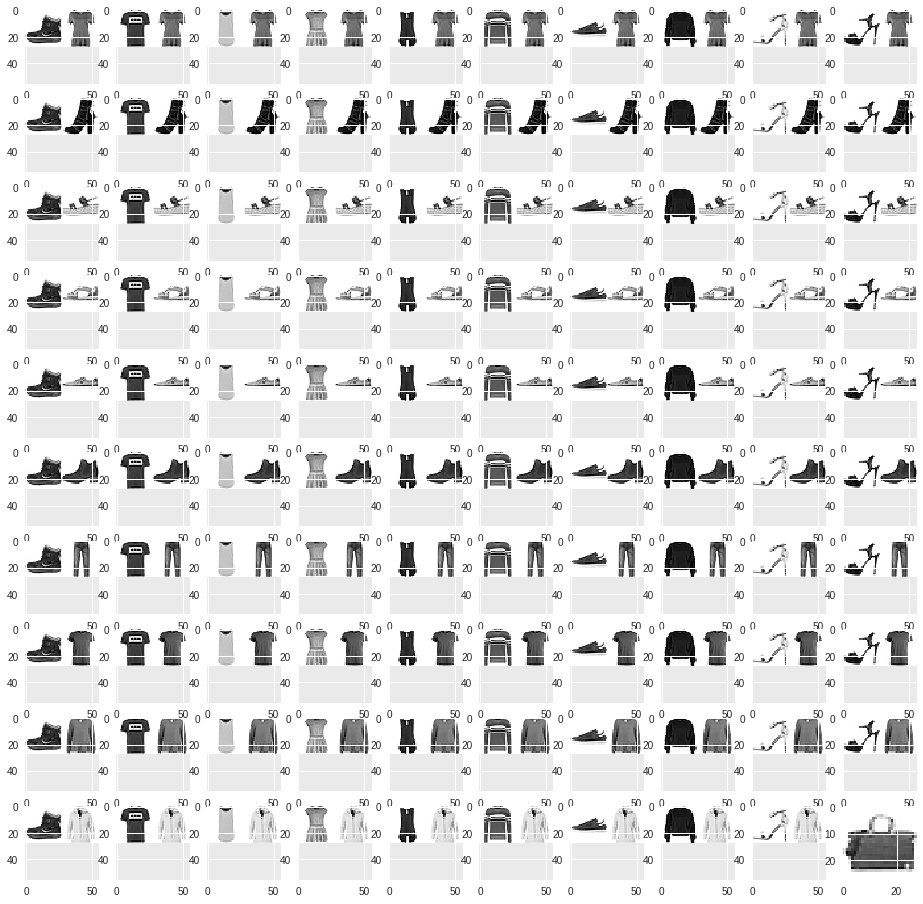

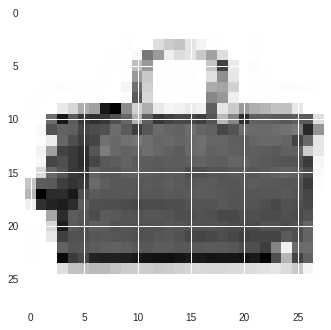

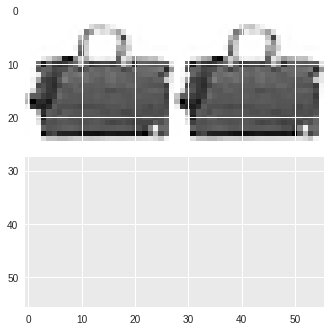

In [28]:
X_trainlarge = load_large_data()

In [0]:
def load_databydatasetname(datasetname):
  if (datasetname == 1):   
    (X_train, _), (_, _) = mnist.load_data()
  if (datasetname == 2):   
    (X_train, _), (_, _) = fashion_mnist.load_data()
  X_train = (X_train.astype(np.float32) - 127.5) / 127.5
  X_train = np.expand_dims(X_train, axis=3)
  return X_train
  

In [0]:
def build_generator(noise_shape=(100,)):
    input = Input(noise_shape)
    x = Dense(128 * 7 * 7, activation="relu")(input)
    x = Reshape((7, 7, 128))(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = UpSampling2D()(x)
    x = Conv2D(128, kernel_size=3, padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = UpSampling2D()(x)
    x = Conv2D(64, kernel_size=3, padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Conv2D(1, kernel_size=3, padding="same")(x)
    out = Activation("tanh")(x)
    model = Model(input, out)
    print("-- Generator -- ")
    model.summary()
    return model

In [0]:
def build_discriminator(img_shape):
    input = Input(img_shape)
    x =Conv2D(32, kernel_size=3, strides=2, padding="same")(input)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.25)(x)
    x = Conv2D(64, kernel_size=3, strides=2, padding="same")(x)
    x = ZeroPadding2D(padding=((0, 1), (0, 1)))(x)
    x = (LeakyReLU(alpha=0.2))(x)
    x = Dropout(0.25)(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Conv2D(128, kernel_size=3, strides=2, padding="same")(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.25)(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Conv2D(256, kernel_size=3, strides=1, padding="same")(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.25)(x)
    x = Flatten()(x)
    out = Dense(1, activation='sigmoid')(x)

    model = Model(input, out)
    print("-- Discriminator -- ")
    model.summary()
    return model

In [0]:
def train(generator1, generator2, discriminator, combined, epochs=2000, batch_size=128, save_interval=50):

    X_train = load_databydatasetname(1)

    num_examples = X_train.shape[0]
    num_batches = int(num_examples / float(batch_size))
    print('Number of examples: ', num_examples)
    print('Number of Batches: ', num_batches)
    print('Number of epochs: ', epochs)

    half_batch = int(batch_size / 2)

    for epoch in range(epochs + 1):
        for batch in range(num_batches):

            # noise images for the batch
            noise = np.random.normal(0, 1, (half_batch, 100))
            fake_images = generator1.predict(noise)
            fake_labels = np.zeros((half_batch, 1))
            
            if(batch % 50 == 0):
              print("NOISE shape ")
              print(noise.shape)
              print("FAKE IMAGES shape")
              print(fake_images.shape)

            # real images for batch
            idx = np.random.randint(0, X_train.shape[0], half_batch)
            real_images = X_train[idx]
            real_labels = np.ones((half_batch, 1))

            # Train the discriminator (real classified as ones and generated as zeros)
            d_loss_real = discriminator.train_on_batch(real_images, real_labels)
            d_loss_fake = discriminator.train_on_batch(fake_images, fake_labels)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            noise = np.random.normal(0, 1, (batch_size, 100))
            # Train the generator
            g_loss = combined.train_on_batch(noise, np.ones((batch_size, 1)))

            # Plot the progress
            print("Epoch %d Batch %d/%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %
                  (epoch,batch, num_batches, d_loss[0], 100 * d_loss[1], g_loss))

            if batch % 50 == 0:
                save_imgs(generator1, epoch, batch)





In [0]:
def save_imgs(generator, epoch, batch):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, 100))
    gen_imgs = generator.predict(noise)

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1
    ##fig.savefig("images/mnist_%d_%d.png" % (epoch, batch))
    plt.show()
    plt.close()

In [0]:
def build_generator_model():

    gen_optimizer = Adam(lr=0.0002, beta_1=0.5)
 
    generator = build_generator()
    generator.compile(loss='binary_crossentropy', optimizer=gen_optimizer)

  
    return generator

In [0]:
def build_classifier_model():

    disc_optimizer = Adam(lr=0.0002, beta_1=0.5)


    discriminator = build_discriminator(img_shape=(28, 28, 1))
    discriminator.compile(loss='binary_crossentropy',
                               optimizer=disc_optimizer,
                               metrics=['accuracy'])


    return  discriminator

In [0]:
def build_combined_model():

    discriminatormymodel = build_classifier_model

    generatormymodel = build_generator_model()
   
    optimizer1 = Adam(lr=0.0002, beta_1=0.5)


    z = Input(shape=(100,))
    img = generatormymodel(z)
    discriminatormymodel.trainable = False
    real = discriminatormymodel(img)
    
    combined = Model(z, real)
    
    combined.compile(loss='binary_crossentropy', optimizer=optimizer1)
    return combined

In [0]:
def getlastlayer(amodel):
  for layer in amodel.layers:
    layerlast = layer
  print(layer)
  print(layer.get_config())
  print(layer.input)
  print(layer.input_shape)
  print(layer.output)
  print('output shape of last is ')
  print(layer.output_shape)
  return layer

In [0]:
def build_models():

    gen1_optimizer = Adam(lr=0.0002, beta_1=0.5)
    gen2_optimizer = Adam(lr=0.0002, beta_1=0.5)
    disc_optimizer = Adam(lr=0.0002, beta_1=0.5)


    discriminator = build_discriminator(img_shape=(28, 28, 1))
    discriminator.compile(loss='binary_crossentropy', optimizer=disc_optimizer,  metrics=['accuracy'])

    generator1 = build_generator()
    
    generator2 = build_generator()

    z = Input(shape=(100,))
    img1 = generator1(z)
    img2 = generator2(z)
    merged = Average(getlastlayer(img1).output, getlastlayer(img2).output)
    discriminator.trainable = False
    real = discriminator(merged)
    combined = Model(z, real)
    
    combined.summary()
    
    generator1.compile(loss='binary_crossentropy', optimizer=gen1_optimizer)
    generator2.compile(loss='binary_crossentropy', optimizer=gen2_optimizer)
    
    combined.compile(loss='binary_crossentropy', optimizer=gen_optimizer)
    return generator, discriminator, combined

In [0]:
def build_modelsNEW():
    z = Input(shape=(100,))
    inputz = z
    x = Dense(128 * 7 * 7, activation="relu")(inputz)
    x = Reshape((7, 7, 128))(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = UpSampling2D()(x)
    x = Conv2D(128, kernel_size=3, padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = UpSampling2D()(x)
    x = Conv2D(64, kernel_size=3, padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Conv2D(1, kernel_size=3, padding="same")(x)
    out = Activation("tanh")(x)    
    generator1 = Model(inputz, out)
    
    inputz2 = z
    x1 = Dense(128 * 7 * 7, activation="relu")(inputz2)
    x1 = Reshape((7, 7, 128))(x1)
    x1 = BatchNormalization(momentum=0.8)(x1)
    x1 = UpSampling2D()(x1)
    x1 = Conv2D(128, kernel_size=3, padding="same")(x1)
    x1 = Activation("relu")(x1)
    x1 = BatchNormalization(momentum=0.8)(x1)
    x1 = UpSampling2D()(x1)
    x1 = Conv2D(64, kernel_size=3, padding="same")(x1)
    x1 = Activation("relu")(x1)
    x1 = BatchNormalization(momentum=0.8)(x1)
    x1 = Conv2D(1, kernel_size=3, padding="same")(x1)
    out1 = Activation("tanh")(x1)    
    generator2 = Model(inputz2, out1)
    
    
    img1 = generator1(z)
    img2 = generator2(z)
    
    
    aoptimizer = Adam(lr=0.0002, beta_1=0.5)   
    discriminator = build_discriminator(img_shape=(28, 28, 1))
    discriminator.compile(loss='binary_crossentropy', optimizer=aoptimizer,  metrics=['accuracy'])
    
    models = [generator1, generator2]
 ##   models = [generator1, generator1]
    outputs = [model.outputs[0] for model in models]
    merged = Average()(outputs)
    discriminator.trainable = False
    real = discriminator(merged)
    combined = Model(z, real)
        
    generator1.compile(loss='binary_crossentropy', optimizer=aoptimizer)
    generator2.compile(loss='binary_crossentropy', optimizer=aoptimizer)  
    combined.compile(loss='binary_crossentropy', optimizer=aoptimizer)
    
    return generator1, generator2, discriminator, combined ,  

In [40]:
generator1, generator2, discriminator, combined = build_modelsNEW()


    
    

    


-- Discriminator -- 
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 14, 14, 32)        320       
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 7, 7, 64)          18496     
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 8, 8, 64)          0         
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 8, 8, 64)          

Number of examples:  60000
Number of Batches:  1875
Number of epochs:  1


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch 0 Batch 0/1875 [D loss: 0.677226, acc.: 71.88%] [G loss: 0.619544]


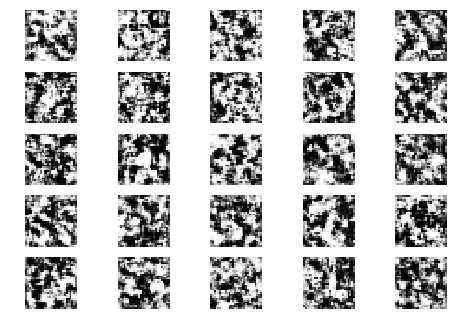

Epoch 0 Batch 1/1875 [D loss: 0.673033, acc.: 62.50%] [G loss: 0.788744]
Epoch 0 Batch 2/1875 [D loss: 0.594639, acc.: 68.75%] [G loss: 0.836761]
Epoch 0 Batch 3/1875 [D loss: 0.467132, acc.: 75.00%] [G loss: 1.105520]
Epoch 0 Batch 4/1875 [D loss: 0.470558, acc.: 81.25%] [G loss: 1.352566]
Epoch 0 Batch 5/1875 [D loss: 0.258190, acc.: 93.75%] [G loss: 1.387264]
Epoch 0 Batch 6/1875 [D loss: 0.362037, acc.: 84.38%] [G loss: 1.344255]
Epoch 0 Batch 7/1875 [D loss: 0.371580, acc.: 84.38%] [G loss: 1.382932]
Epoch 0 Batch 8/1875 [D loss: 0.251377, acc.: 96.88%] [G loss: 1.571040]
Epoch 0 Batch 9/1875 [D loss: 0.363451, acc.: 84.38%] [G loss: 1.773018]
Epoch 0 Batch 10/1875 [D loss: 0.406702, acc.: 75.00%] [G loss: 1.733937]
Epoch 0 Batch 11/1875 [D loss: 0.310034, acc.: 87.50%] [G loss: 1.854587]
Epoch 0 Batch 12/1875 [D loss: 0.235872, acc.: 90.62%] [G loss: 1.841738]
Epoch 0 Batch 13/1875 [D loss: 0.282351, acc.: 90.62%] [G loss: 1.832166]
Epoch 0 Batch 14/1875 [D loss: 0.231660, acc.: 

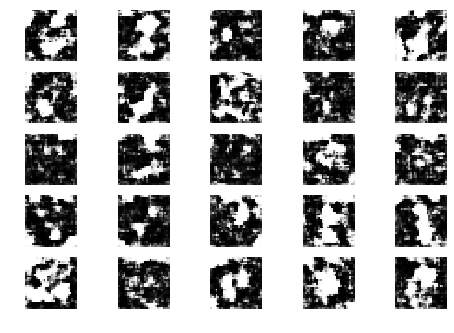

Epoch 0 Batch 51/1875 [D loss: 0.041620, acc.: 100.00%] [G loss: 1.158534]
Epoch 0 Batch 52/1875 [D loss: 0.146520, acc.: 93.75%] [G loss: 1.159547]
Epoch 0 Batch 53/1875 [D loss: 0.068214, acc.: 96.88%] [G loss: 0.837057]
Epoch 0 Batch 54/1875 [D loss: 0.031804, acc.: 100.00%] [G loss: 0.620536]
Epoch 0 Batch 55/1875 [D loss: 0.047253, acc.: 100.00%] [G loss: 0.247007]
Epoch 0 Batch 56/1875 [D loss: 0.218489, acc.: 87.50%] [G loss: 1.642565]
Epoch 0 Batch 57/1875 [D loss: 0.150824, acc.: 93.75%] [G loss: 1.057718]
Epoch 0 Batch 58/1875 [D loss: 0.092753, acc.: 100.00%] [G loss: 0.464703]
Epoch 0 Batch 59/1875 [D loss: 0.146826, acc.: 93.75%] [G loss: 0.436504]
Epoch 0 Batch 60/1875 [D loss: 0.067422, acc.: 100.00%] [G loss: 0.608584]
Epoch 0 Batch 61/1875 [D loss: 0.172556, acc.: 96.88%] [G loss: 0.657462]
Epoch 0 Batch 62/1875 [D loss: 0.473355, acc.: 78.12%] [G loss: 0.145754]
Epoch 0 Batch 63/1875 [D loss: 0.765639, acc.: 65.62%] [G loss: 2.309553]
Epoch 0 Batch 64/1875 [D loss: 0.

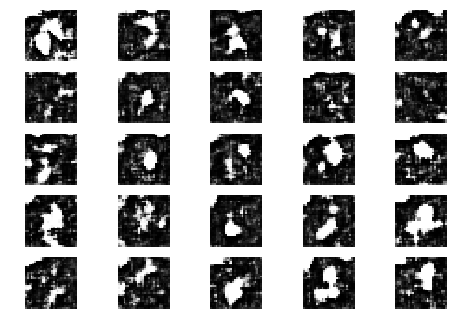

Epoch 0 Batch 101/1875 [D loss: 0.075702, acc.: 100.00%] [G loss: 0.047955]
Epoch 0 Batch 102/1875 [D loss: 0.013765, acc.: 100.00%] [G loss: 0.099843]
Epoch 0 Batch 103/1875 [D loss: 0.070566, acc.: 100.00%] [G loss: 0.040649]
Epoch 0 Batch 104/1875 [D loss: 0.076649, acc.: 100.00%] [G loss: 0.023849]
Epoch 0 Batch 105/1875 [D loss: 0.065255, acc.: 96.88%] [G loss: 0.015591]
Epoch 0 Batch 106/1875 [D loss: 0.204119, acc.: 90.62%] [G loss: 0.138977]
Epoch 0 Batch 107/1875 [D loss: 0.016920, acc.: 100.00%] [G loss: 0.168090]
Epoch 0 Batch 108/1875 [D loss: 0.259870, acc.: 90.62%] [G loss: 0.003499]
Epoch 0 Batch 109/1875 [D loss: 0.105147, acc.: 96.88%] [G loss: 0.013937]
Epoch 0 Batch 110/1875 [D loss: 0.020807, acc.: 100.00%] [G loss: 0.008425]
Epoch 0 Batch 111/1875 [D loss: 0.011895, acc.: 100.00%] [G loss: 0.022336]
Epoch 0 Batch 112/1875 [D loss: 0.027005, acc.: 100.00%] [G loss: 0.014983]
Epoch 0 Batch 113/1875 [D loss: 0.367348, acc.: 81.25%] [G loss: 0.000553]
Epoch 0 Batch 114

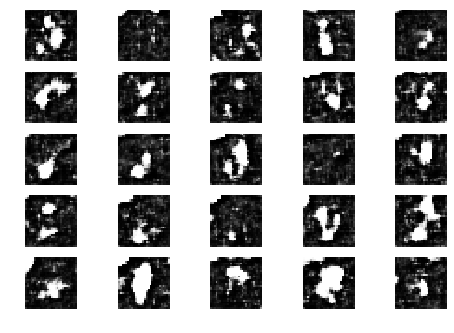

Epoch 0 Batch 151/1875 [D loss: 0.337758, acc.: 87.50%] [G loss: 0.008147]
Epoch 0 Batch 152/1875 [D loss: 0.017584, acc.: 100.00%] [G loss: 0.002837]
Epoch 0 Batch 153/1875 [D loss: 0.052613, acc.: 100.00%] [G loss: 0.013434]
Epoch 0 Batch 154/1875 [D loss: 0.051273, acc.: 100.00%] [G loss: 0.012214]
Epoch 0 Batch 155/1875 [D loss: 0.129121, acc.: 93.75%] [G loss: 0.009470]
Epoch 0 Batch 156/1875 [D loss: 0.024640, acc.: 100.00%] [G loss: 0.002264]
Epoch 0 Batch 157/1875 [D loss: 0.006829, acc.: 100.00%] [G loss: 0.012322]
Epoch 0 Batch 158/1875 [D loss: 0.064345, acc.: 96.88%] [G loss: 0.073852]
Epoch 0 Batch 159/1875 [D loss: 0.054752, acc.: 96.88%] [G loss: 0.029691]
Epoch 0 Batch 160/1875 [D loss: 0.022578, acc.: 100.00%] [G loss: 0.008347]
Epoch 0 Batch 161/1875 [D loss: 0.351101, acc.: 87.50%] [G loss: 0.008185]
Epoch 0 Batch 162/1875 [D loss: 0.050239, acc.: 96.88%] [G loss: 0.008632]
Epoch 0 Batch 163/1875 [D loss: 0.005679, acc.: 100.00%] [G loss: 0.013578]
Epoch 0 Batch 164/

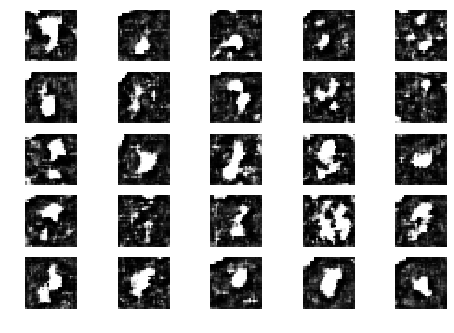

Epoch 0 Batch 201/1875 [D loss: 0.007506, acc.: 100.00%] [G loss: 0.013938]
Epoch 0 Batch 202/1875 [D loss: 0.104632, acc.: 96.88%] [G loss: 0.027017]
Epoch 0 Batch 203/1875 [D loss: 0.143812, acc.: 90.62%] [G loss: 0.000640]
Epoch 0 Batch 204/1875 [D loss: 0.207734, acc.: 90.62%] [G loss: 0.006118]
Epoch 0 Batch 205/1875 [D loss: 0.055087, acc.: 100.00%] [G loss: 0.012142]
Epoch 0 Batch 206/1875 [D loss: 0.004637, acc.: 100.00%] [G loss: 0.007092]
Epoch 0 Batch 207/1875 [D loss: 0.006473, acc.: 100.00%] [G loss: 0.002965]
Epoch 0 Batch 208/1875 [D loss: 0.071102, acc.: 100.00%] [G loss: 0.002359]
Epoch 0 Batch 209/1875 [D loss: 0.005717, acc.: 100.00%] [G loss: 0.002798]
Epoch 0 Batch 210/1875 [D loss: 0.007466, acc.: 100.00%] [G loss: 0.000698]
Epoch 0 Batch 211/1875 [D loss: 0.109459, acc.: 93.75%] [G loss: 0.001930]
Epoch 0 Batch 212/1875 [D loss: 0.007348, acc.: 100.00%] [G loss: 0.003319]
Epoch 0 Batch 213/1875 [D loss: 0.092647, acc.: 96.88%] [G loss: 0.002998]
Epoch 0 Batch 214

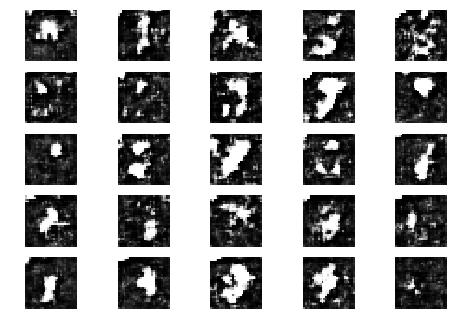

Epoch 0 Batch 251/1875 [D loss: 0.005664, acc.: 100.00%] [G loss: 0.002300]
Epoch 0 Batch 252/1875 [D loss: 0.038356, acc.: 100.00%] [G loss: 0.083209]
Epoch 0 Batch 253/1875 [D loss: 0.003481, acc.: 100.00%] [G loss: 0.002472]
Epoch 0 Batch 254/1875 [D loss: 0.182470, acc.: 93.75%] [G loss: 0.000105]
Epoch 0 Batch 255/1875 [D loss: 0.003617, acc.: 100.00%] [G loss: 0.001246]
Epoch 0 Batch 256/1875 [D loss: 0.120017, acc.: 93.75%] [G loss: 0.001392]
Epoch 0 Batch 257/1875 [D loss: 0.000557, acc.: 100.00%] [G loss: 0.004577]
Epoch 0 Batch 258/1875 [D loss: 0.001831, acc.: 100.00%] [G loss: 0.029674]
Epoch 0 Batch 259/1875 [D loss: 0.009080, acc.: 100.00%] [G loss: 0.023699]
Epoch 0 Batch 260/1875 [D loss: 0.012876, acc.: 100.00%] [G loss: 0.006017]
Epoch 0 Batch 261/1875 [D loss: 0.026031, acc.: 100.00%] [G loss: 0.046855]
Epoch 0 Batch 262/1875 [D loss: 0.002309, acc.: 100.00%] [G loss: 0.009799]
Epoch 0 Batch 263/1875 [D loss: 0.004938, acc.: 100.00%] [G loss: 0.015091]
Epoch 0 Batch 

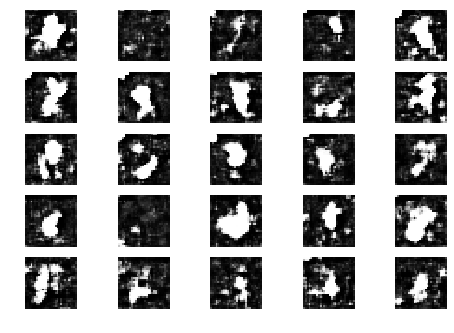

Epoch 0 Batch 301/1875 [D loss: 0.229200, acc.: 87.50%] [G loss: 0.016171]
Epoch 0 Batch 302/1875 [D loss: 0.092164, acc.: 93.75%] [G loss: 0.035593]
Epoch 0 Batch 303/1875 [D loss: 0.001061, acc.: 100.00%] [G loss: 0.002987]
Epoch 0 Batch 304/1875 [D loss: 0.122787, acc.: 96.88%] [G loss: 0.000513]
Epoch 0 Batch 305/1875 [D loss: 0.002099, acc.: 100.00%] [G loss: 0.001752]
Epoch 0 Batch 306/1875 [D loss: 0.008239, acc.: 100.00%] [G loss: 0.001399]
Epoch 0 Batch 307/1875 [D loss: 0.004278, acc.: 100.00%] [G loss: 0.000796]
Epoch 0 Batch 308/1875 [D loss: 0.009955, acc.: 100.00%] [G loss: 0.001709]
Epoch 0 Batch 309/1875 [D loss: 0.135169, acc.: 96.88%] [G loss: 0.000279]
Epoch 0 Batch 310/1875 [D loss: 0.035481, acc.: 96.88%] [G loss: 0.000767]
Epoch 0 Batch 311/1875 [D loss: 0.001028, acc.: 100.00%] [G loss: 0.000944]
Epoch 0 Batch 312/1875 [D loss: 0.024466, acc.: 100.00%] [G loss: 0.001506]
Epoch 0 Batch 313/1875 [D loss: 0.043057, acc.: 100.00%] [G loss: 0.001860]
Epoch 0 Batch 314

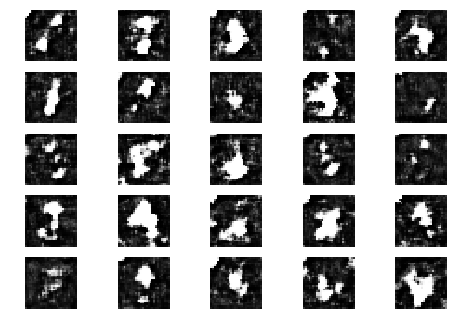

Epoch 0 Batch 351/1875 [D loss: 0.282444, acc.: 87.50%] [G loss: 0.015309]
Epoch 0 Batch 352/1875 [D loss: 0.006641, acc.: 100.00%] [G loss: 0.180526]
Epoch 0 Batch 353/1875 [D loss: 0.597800, acc.: 75.00%] [G loss: 0.000062]
Epoch 0 Batch 354/1875 [D loss: 0.029296, acc.: 96.88%] [G loss: 0.000047]
Epoch 0 Batch 355/1875 [D loss: 0.130357, acc.: 93.75%] [G loss: 0.000025]
Epoch 0 Batch 356/1875 [D loss: 0.050646, acc.: 96.88%] [G loss: 0.000275]
Epoch 0 Batch 357/1875 [D loss: 0.024184, acc.: 100.00%] [G loss: 0.002209]
Epoch 0 Batch 358/1875 [D loss: 0.009958, acc.: 100.00%] [G loss: 0.000763]
Epoch 0 Batch 359/1875 [D loss: 0.001504, acc.: 100.00%] [G loss: 0.000219]
Epoch 0 Batch 360/1875 [D loss: 0.074312, acc.: 93.75%] [G loss: 0.029701]
Epoch 0 Batch 361/1875 [D loss: 0.019428, acc.: 100.00%] [G loss: 0.001362]
Epoch 0 Batch 362/1875 [D loss: 0.030098, acc.: 100.00%] [G loss: 0.001696]
Epoch 0 Batch 363/1875 [D loss: 0.004360, acc.: 100.00%] [G loss: 0.000896]
Epoch 0 Batch 364/

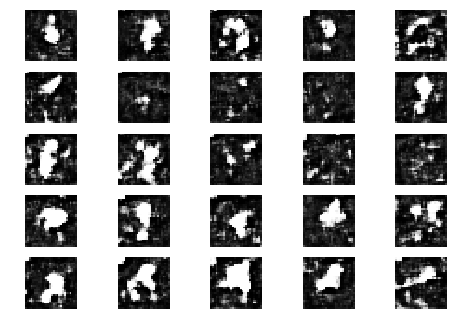

Epoch 0 Batch 401/1875 [D loss: 0.003856, acc.: 100.00%] [G loss: 0.000212]
Epoch 0 Batch 402/1875 [D loss: 0.005971, acc.: 100.00%] [G loss: 0.000184]
Epoch 0 Batch 403/1875 [D loss: 0.027935, acc.: 100.00%] [G loss: 0.008270]
Epoch 0 Batch 404/1875 [D loss: 0.001391, acc.: 100.00%] [G loss: 0.000638]
Epoch 0 Batch 405/1875 [D loss: 0.000489, acc.: 100.00%] [G loss: 0.000178]
Epoch 0 Batch 406/1875 [D loss: 0.063448, acc.: 96.88%] [G loss: 0.001432]
Epoch 0 Batch 407/1875 [D loss: 0.003801, acc.: 100.00%] [G loss: 0.005430]
Epoch 0 Batch 408/1875 [D loss: 0.012242, acc.: 100.00%] [G loss: 0.003977]
Epoch 0 Batch 409/1875 [D loss: 0.000763, acc.: 100.00%] [G loss: 0.002129]
Epoch 0 Batch 410/1875 [D loss: 0.008193, acc.: 100.00%] [G loss: 0.001367]
Epoch 0 Batch 411/1875 [D loss: 0.007158, acc.: 100.00%] [G loss: 0.000789]
Epoch 0 Batch 412/1875 [D loss: 0.015534, acc.: 100.00%] [G loss: 0.000284]
Epoch 0 Batch 413/1875 [D loss: 0.000790, acc.: 100.00%] [G loss: 0.000317]
Epoch 0 Batch

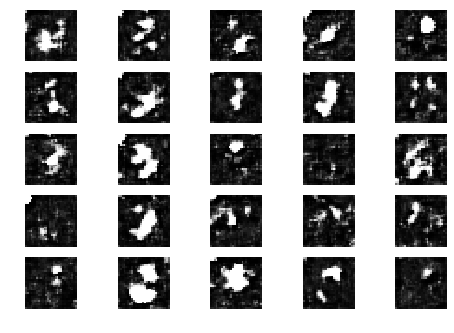

Epoch 0 Batch 451/1875 [D loss: 0.009273, acc.: 100.00%] [G loss: 0.000123]
Epoch 0 Batch 452/1875 [D loss: 0.018887, acc.: 100.00%] [G loss: 0.000728]
Epoch 0 Batch 453/1875 [D loss: 0.024595, acc.: 100.00%] [G loss: 0.000184]
Epoch 0 Batch 454/1875 [D loss: 0.018384, acc.: 100.00%] [G loss: 0.000124]
Epoch 0 Batch 455/1875 [D loss: 0.000150, acc.: 100.00%] [G loss: 0.000435]
Epoch 0 Batch 456/1875 [D loss: 0.000154, acc.: 100.00%] [G loss: 0.011596]
Epoch 0 Batch 457/1875 [D loss: 0.001436, acc.: 100.00%] [G loss: 0.003195]
Epoch 0 Batch 458/1875 [D loss: 0.000115, acc.: 100.00%] [G loss: 0.001721]
Epoch 0 Batch 459/1875 [D loss: 0.059438, acc.: 96.88%] [G loss: 0.000135]
Epoch 0 Batch 460/1875 [D loss: 0.196877, acc.: 93.75%] [G loss: 0.000296]
Epoch 0 Batch 461/1875 [D loss: 0.000099, acc.: 100.00%] [G loss: 0.001899]
Epoch 0 Batch 462/1875 [D loss: 0.000194, acc.: 100.00%] [G loss: 0.007962]
Epoch 0 Batch 463/1875 [D loss: 0.569467, acc.: 84.38%] [G loss: 0.000007]
Epoch 0 Batch 4

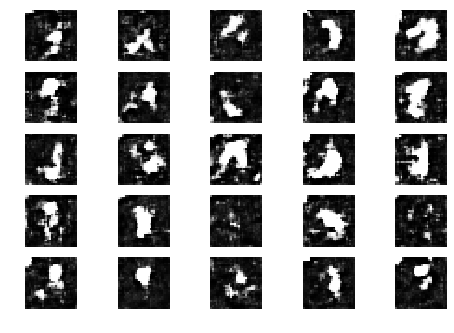

Epoch 0 Batch 501/1875 [D loss: 0.001097, acc.: 100.00%] [G loss: 0.000090]
Epoch 0 Batch 502/1875 [D loss: 0.001096, acc.: 100.00%] [G loss: 0.000031]
Epoch 0 Batch 503/1875 [D loss: 0.002123, acc.: 100.00%] [G loss: 0.000782]
Epoch 0 Batch 504/1875 [D loss: 0.002475, acc.: 100.00%] [G loss: 0.000132]
Epoch 0 Batch 505/1875 [D loss: 0.001804, acc.: 100.00%] [G loss: 0.000131]
Epoch 0 Batch 506/1875 [D loss: 0.000827, acc.: 100.00%] [G loss: 0.000028]
Epoch 0 Batch 507/1875 [D loss: 0.000734, acc.: 100.00%] [G loss: 0.000223]
Epoch 0 Batch 508/1875 [D loss: 0.000293, acc.: 100.00%] [G loss: 0.000390]
Epoch 0 Batch 509/1875 [D loss: 0.001434, acc.: 100.00%] [G loss: 0.000025]
Epoch 0 Batch 510/1875 [D loss: 0.026132, acc.: 100.00%] [G loss: 0.000049]
Epoch 0 Batch 511/1875 [D loss: 0.072087, acc.: 96.88%] [G loss: 0.000082]
Epoch 0 Batch 512/1875 [D loss: 0.005886, acc.: 100.00%] [G loss: 0.000291]
Epoch 0 Batch 513/1875 [D loss: 0.004883, acc.: 100.00%] [G loss: 0.000223]
Epoch 0 Batch

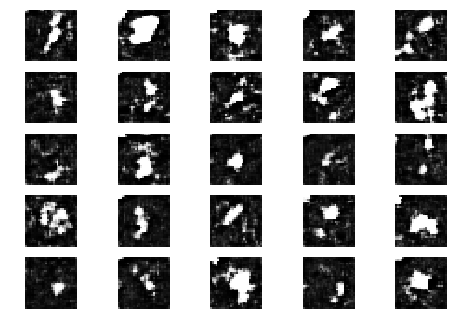

Epoch 0 Batch 551/1875 [D loss: 0.033512, acc.: 100.00%] [G loss: 0.000105]
Epoch 0 Batch 552/1875 [D loss: 0.004485, acc.: 100.00%] [G loss: 0.000048]
Epoch 0 Batch 553/1875 [D loss: 0.010509, acc.: 100.00%] [G loss: 0.000014]
Epoch 0 Batch 554/1875 [D loss: 0.001552, acc.: 100.00%] [G loss: 0.000050]
Epoch 0 Batch 555/1875 [D loss: 0.001977, acc.: 100.00%] [G loss: 0.000039]
Epoch 0 Batch 556/1875 [D loss: 0.010119, acc.: 100.00%] [G loss: 0.000060]
Epoch 0 Batch 557/1875 [D loss: 0.000140, acc.: 100.00%] [G loss: 0.000607]
Epoch 0 Batch 558/1875 [D loss: 0.000189, acc.: 100.00%] [G loss: 0.000149]
Epoch 0 Batch 559/1875 [D loss: 0.000075, acc.: 100.00%] [G loss: 0.000044]
Epoch 0 Batch 560/1875 [D loss: 0.063839, acc.: 96.88%] [G loss: 0.000002]
Epoch 0 Batch 561/1875 [D loss: 0.108360, acc.: 90.62%] [G loss: 0.000021]
Epoch 0 Batch 562/1875 [D loss: 0.000011, acc.: 100.00%] [G loss: 0.000404]
Epoch 0 Batch 563/1875 [D loss: 0.000264, acc.: 100.00%] [G loss: 0.000108]
Epoch 0 Batch 

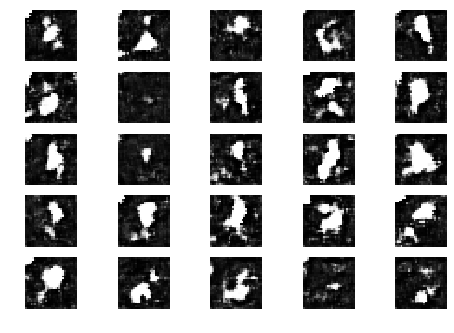

Epoch 0 Batch 601/1875 [D loss: 0.000748, acc.: 100.00%] [G loss: 0.000289]
Epoch 0 Batch 602/1875 [D loss: 0.000200, acc.: 100.00%] [G loss: 0.000132]
Epoch 0 Batch 603/1875 [D loss: 0.000107, acc.: 100.00%] [G loss: 0.004740]
Epoch 0 Batch 604/1875 [D loss: 0.000806, acc.: 100.00%] [G loss: 0.000162]
Epoch 0 Batch 605/1875 [D loss: 0.022295, acc.: 100.00%] [G loss: 0.000278]
Epoch 0 Batch 606/1875 [D loss: 0.000167, acc.: 100.00%] [G loss: 0.000059]
Epoch 0 Batch 607/1875 [D loss: 0.004051, acc.: 100.00%] [G loss: 0.000402]
Epoch 0 Batch 608/1875 [D loss: 0.000693, acc.: 100.00%] [G loss: 0.000037]
Epoch 0 Batch 609/1875 [D loss: 0.000432, acc.: 100.00%] [G loss: 0.000107]
Epoch 0 Batch 610/1875 [D loss: 0.000145, acc.: 100.00%] [G loss: 0.000115]
Epoch 0 Batch 611/1875 [D loss: 0.000850, acc.: 100.00%] [G loss: 0.000028]
Epoch 0 Batch 612/1875 [D loss: 0.003105, acc.: 100.00%] [G loss: 0.000100]
Epoch 0 Batch 613/1875 [D loss: 0.000829, acc.: 100.00%] [G loss: 0.000081]
Epoch 0 Batc

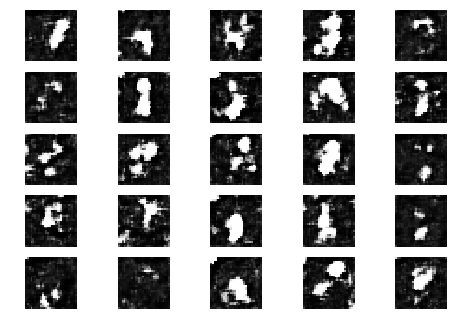

Epoch 0 Batch 651/1875 [D loss: 0.000056, acc.: 100.00%] [G loss: 0.000166]
Epoch 0 Batch 652/1875 [D loss: 0.000562, acc.: 100.00%] [G loss: 0.009944]
Epoch 0 Batch 653/1875 [D loss: 0.006429, acc.: 100.00%] [G loss: 0.000027]
Epoch 0 Batch 654/1875 [D loss: 0.003657, acc.: 100.00%] [G loss: 0.000147]
Epoch 0 Batch 655/1875 [D loss: 0.002331, acc.: 100.00%] [G loss: 0.000266]
Epoch 0 Batch 656/1875 [D loss: 0.000196, acc.: 100.00%] [G loss: 0.000022]
Epoch 0 Batch 657/1875 [D loss: 0.000257, acc.: 100.00%] [G loss: 0.000009]
Epoch 0 Batch 658/1875 [D loss: 0.004739, acc.: 100.00%] [G loss: 0.000033]
Epoch 0 Batch 659/1875 [D loss: 0.000554, acc.: 100.00%] [G loss: 0.000019]
Epoch 0 Batch 660/1875 [D loss: 0.001260, acc.: 100.00%] [G loss: 0.000226]
Epoch 0 Batch 661/1875 [D loss: 0.000239, acc.: 100.00%] [G loss: 0.000034]
Epoch 0 Batch 662/1875 [D loss: 0.000171, acc.: 100.00%] [G loss: 0.000510]
Epoch 0 Batch 663/1875 [D loss: 0.000163, acc.: 100.00%] [G loss: 0.000032]
Epoch 0 Batc

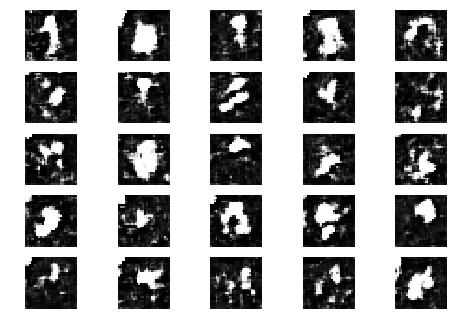

Epoch 0 Batch 701/1875 [D loss: 0.001207, acc.: 100.00%] [G loss: 0.000015]
Epoch 0 Batch 702/1875 [D loss: 0.039685, acc.: 96.88%] [G loss: 0.000001]
Epoch 0 Batch 703/1875 [D loss: 0.000428, acc.: 100.00%] [G loss: 0.000006]
Epoch 0 Batch 704/1875 [D loss: 0.003462, acc.: 100.00%] [G loss: 0.000007]
Epoch 0 Batch 705/1875 [D loss: 0.000169, acc.: 100.00%] [G loss: 0.000003]
Epoch 0 Batch 706/1875 [D loss: 0.000014, acc.: 100.00%] [G loss: 0.000037]
Epoch 0 Batch 707/1875 [D loss: 0.000058, acc.: 100.00%] [G loss: 0.000001]
Epoch 0 Batch 708/1875 [D loss: 0.000384, acc.: 100.00%] [G loss: 0.000003]
Epoch 0 Batch 709/1875 [D loss: 0.000951, acc.: 100.00%] [G loss: 0.000008]
Epoch 0 Batch 710/1875 [D loss: 0.000039, acc.: 100.00%] [G loss: 0.000053]
Epoch 0 Batch 711/1875 [D loss: 0.000554, acc.: 100.00%] [G loss: 0.000003]
Epoch 0 Batch 712/1875 [D loss: 0.000854, acc.: 100.00%] [G loss: 0.000002]
Epoch 0 Batch 713/1875 [D loss: 0.000225, acc.: 100.00%] [G loss: 0.000036]
Epoch 0 Batch

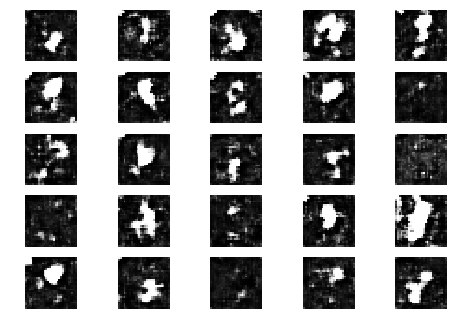

Epoch 0 Batch 751/1875 [D loss: 0.003098, acc.: 100.00%] [G loss: 0.000121]
Epoch 0 Batch 752/1875 [D loss: 0.001012, acc.: 100.00%] [G loss: 0.000017]
Epoch 0 Batch 753/1875 [D loss: 0.000365, acc.: 100.00%] [G loss: 0.000041]
Epoch 0 Batch 754/1875 [D loss: 0.001059, acc.: 100.00%] [G loss: 0.000056]
Epoch 0 Batch 755/1875 [D loss: 0.001654, acc.: 100.00%] [G loss: 0.000267]
Epoch 0 Batch 756/1875 [D loss: 0.000054, acc.: 100.00%] [G loss: 0.000023]
Epoch 0 Batch 757/1875 [D loss: 0.000020, acc.: 100.00%] [G loss: 0.000931]
Epoch 0 Batch 758/1875 [D loss: 0.015980, acc.: 100.00%] [G loss: 0.000020]
Epoch 0 Batch 759/1875 [D loss: 0.002595, acc.: 100.00%] [G loss: 0.000026]
Epoch 0 Batch 760/1875 [D loss: 0.000023, acc.: 100.00%] [G loss: 0.000029]
Epoch 0 Batch 761/1875 [D loss: 0.000275, acc.: 100.00%] [G loss: 0.000020]
Epoch 0 Batch 762/1875 [D loss: 0.005442, acc.: 100.00%] [G loss: 0.000016]
Epoch 0 Batch 763/1875 [D loss: 0.000034, acc.: 100.00%] [G loss: 0.000131]
Epoch 0 Batc

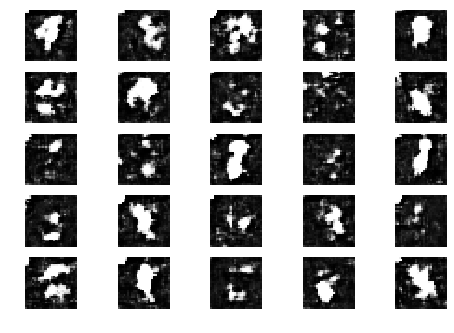

Epoch 0 Batch 801/1875 [D loss: 0.000536, acc.: 100.00%] [G loss: 0.000006]
Epoch 0 Batch 802/1875 [D loss: 0.010169, acc.: 100.00%] [G loss: 0.000022]
Epoch 0 Batch 803/1875 [D loss: 0.000328, acc.: 100.00%] [G loss: 0.000001]
Epoch 0 Batch 804/1875 [D loss: 0.000764, acc.: 100.00%] [G loss: 0.000002]
Epoch 0 Batch 805/1875 [D loss: 0.010106, acc.: 100.00%] [G loss: 0.000003]
Epoch 0 Batch 806/1875 [D loss: 0.000252, acc.: 100.00%] [G loss: 0.000004]
Epoch 0 Batch 807/1875 [D loss: 0.000194, acc.: 100.00%] [G loss: 0.000003]
Epoch 0 Batch 808/1875 [D loss: 0.002402, acc.: 100.00%] [G loss: 0.000012]
Epoch 0 Batch 809/1875 [D loss: 0.001144, acc.: 100.00%] [G loss: 0.000213]
Epoch 0 Batch 810/1875 [D loss: 0.000466, acc.: 100.00%] [G loss: 0.000104]
Epoch 0 Batch 811/1875 [D loss: 0.010216, acc.: 100.00%] [G loss: 0.000790]
Epoch 0 Batch 812/1875 [D loss: 0.001097, acc.: 100.00%] [G loss: 0.000288]
Epoch 0 Batch 813/1875 [D loss: 0.000646, acc.: 100.00%] [G loss: 0.000091]
Epoch 0 Batc

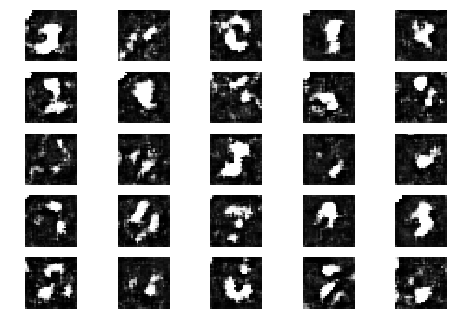

Epoch 0 Batch 851/1875 [D loss: 0.004074, acc.: 100.00%] [G loss: 0.000003]
Epoch 0 Batch 852/1875 [D loss: 0.000249, acc.: 100.00%] [G loss: 0.000007]
Epoch 0 Batch 853/1875 [D loss: 0.001655, acc.: 100.00%] [G loss: 0.000030]
Epoch 0 Batch 854/1875 [D loss: 0.000025, acc.: 100.00%] [G loss: 0.000002]
Epoch 0 Batch 855/1875 [D loss: 0.000001, acc.: 100.00%] [G loss: 0.000001]
Epoch 0 Batch 856/1875 [D loss: 0.000078, acc.: 100.00%] [G loss: 0.000025]
Epoch 0 Batch 857/1875 [D loss: 0.000026, acc.: 100.00%] [G loss: 0.000626]
Epoch 0 Batch 858/1875 [D loss: 0.001313, acc.: 100.00%] [G loss: 0.000018]
Epoch 0 Batch 859/1875 [D loss: 0.000784, acc.: 100.00%] [G loss: 0.000005]
Epoch 0 Batch 860/1875 [D loss: 0.000085, acc.: 100.00%] [G loss: 0.000023]
Epoch 0 Batch 861/1875 [D loss: 0.000712, acc.: 100.00%] [G loss: 0.000013]
Epoch 0 Batch 862/1875 [D loss: 0.000174, acc.: 100.00%] [G loss: 0.000003]
Epoch 0 Batch 863/1875 [D loss: 0.000069, acc.: 100.00%] [G loss: 0.000004]
Epoch 0 Batc

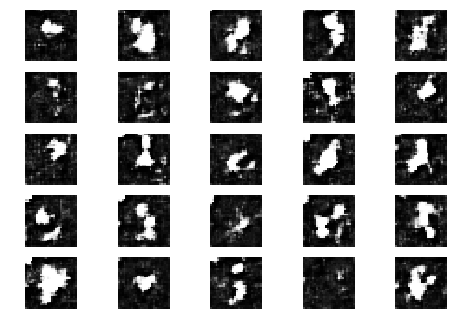

Epoch 0 Batch 901/1875 [D loss: 0.000241, acc.: 100.00%] [G loss: 0.000005]
Epoch 0 Batch 902/1875 [D loss: 0.023884, acc.: 100.00%] [G loss: 0.000007]
Epoch 0 Batch 903/1875 [D loss: 0.000155, acc.: 100.00%] [G loss: 0.000002]
Epoch 0 Batch 904/1875 [D loss: 0.001250, acc.: 100.00%] [G loss: 0.000001]
Epoch 0 Batch 905/1875 [D loss: 0.000876, acc.: 100.00%] [G loss: 0.000001]
Epoch 0 Batch 906/1875 [D loss: 0.000738, acc.: 100.00%] [G loss: 0.000000]
Epoch 0 Batch 907/1875 [D loss: 0.000069, acc.: 100.00%] [G loss: 0.000002]
Epoch 0 Batch 908/1875 [D loss: 0.001552, acc.: 100.00%] [G loss: 0.000001]
Epoch 0 Batch 909/1875 [D loss: 0.005644, acc.: 100.00%] [G loss: 0.000001]
Epoch 0 Batch 910/1875 [D loss: 0.000014, acc.: 100.00%] [G loss: 0.000021]
Epoch 0 Batch 911/1875 [D loss: 0.000005, acc.: 100.00%] [G loss: 0.000007]
Epoch 0 Batch 912/1875 [D loss: 0.004900, acc.: 100.00%] [G loss: 0.000001]
Epoch 0 Batch 913/1875 [D loss: 0.001372, acc.: 100.00%] [G loss: 0.000004]
Epoch 0 Batc

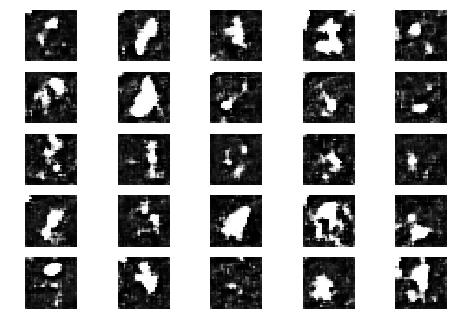

Epoch 0 Batch 951/1875 [D loss: 0.000010, acc.: 100.00%] [G loss: 0.000000]
Epoch 0 Batch 952/1875 [D loss: 0.000473, acc.: 100.00%] [G loss: 0.000001]
Epoch 0 Batch 953/1875 [D loss: 0.006438, acc.: 100.00%] [G loss: 0.000006]
Epoch 0 Batch 954/1875 [D loss: 0.000691, acc.: 100.00%] [G loss: 0.000016]
Epoch 0 Batch 955/1875 [D loss: 0.021940, acc.: 100.00%] [G loss: 0.000002]
Epoch 0 Batch 956/1875 [D loss: 0.001014, acc.: 100.00%] [G loss: 0.000016]
Epoch 0 Batch 957/1875 [D loss: 0.105672, acc.: 96.88%] [G loss: 0.000002]
Epoch 0 Batch 958/1875 [D loss: 0.000423, acc.: 100.00%] [G loss: 0.000000]
Epoch 0 Batch 959/1875 [D loss: 0.001537, acc.: 100.00%] [G loss: 0.000000]
Epoch 0 Batch 960/1875 [D loss: 0.000788, acc.: 100.00%] [G loss: 0.000001]
Epoch 0 Batch 961/1875 [D loss: 0.328607, acc.: 87.50%] [G loss: 0.020764]
Epoch 0 Batch 962/1875 [D loss: 0.039115, acc.: 96.88%] [G loss: 0.561728]
Epoch 0 Batch 963/1875 [D loss: 3.519226, acc.: 25.00%] [G loss: 0.000000]
Epoch 0 Batch 96

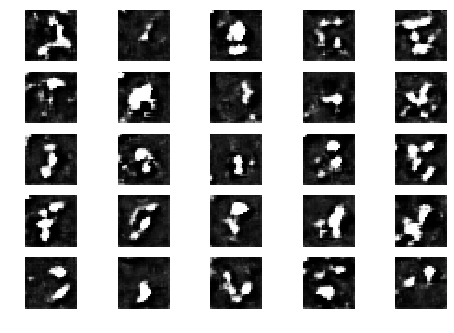

Epoch 0 Batch 1001/1875 [D loss: 0.391035, acc.: 84.38%] [G loss: 0.000947]
Epoch 0 Batch 1002/1875 [D loss: 0.002023, acc.: 100.00%] [G loss: 0.005673]
Epoch 0 Batch 1003/1875 [D loss: 0.135319, acc.: 93.75%] [G loss: 0.014948]
Epoch 0 Batch 1004/1875 [D loss: 0.100314, acc.: 93.75%] [G loss: 0.007322]
Epoch 0 Batch 1005/1875 [D loss: 0.064704, acc.: 96.88%] [G loss: 0.001750]
Epoch 0 Batch 1006/1875 [D loss: 0.000753, acc.: 100.00%] [G loss: 0.003822]
Epoch 0 Batch 1007/1875 [D loss: 0.028681, acc.: 100.00%] [G loss: 0.033508]
Epoch 0 Batch 1008/1875 [D loss: 0.011905, acc.: 100.00%] [G loss: 0.000283]
Epoch 0 Batch 1009/1875 [D loss: 0.127630, acc.: 93.75%] [G loss: 0.000565]
Epoch 0 Batch 1010/1875 [D loss: 0.026808, acc.: 100.00%] [G loss: 0.002881]
Epoch 0 Batch 1011/1875 [D loss: 0.023790, acc.: 100.00%] [G loss: 0.002661]
Epoch 0 Batch 1012/1875 [D loss: 0.357633, acc.: 81.25%] [G loss: 0.046763]
Epoch 0 Batch 1013/1875 [D loss: 0.021089, acc.: 100.00%] [G loss: 0.000235]
Epoch

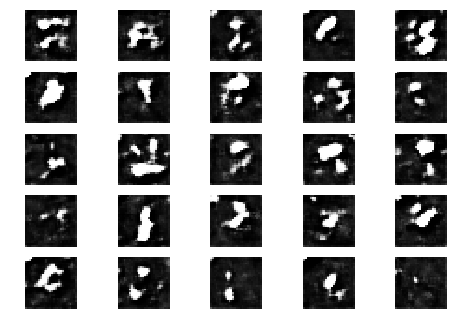

Epoch 0 Batch 1051/1875 [D loss: 0.006744, acc.: 100.00%] [G loss: 0.000034]
Epoch 0 Batch 1052/1875 [D loss: 0.015295, acc.: 100.00%] [G loss: 0.000437]
Epoch 0 Batch 1053/1875 [D loss: 0.125268, acc.: 93.75%] [G loss: 0.020084]
Epoch 0 Batch 1054/1875 [D loss: 0.029263, acc.: 100.00%] [G loss: 0.000995]
Epoch 0 Batch 1055/1875 [D loss: 0.052108, acc.: 96.88%] [G loss: 0.002981]
Epoch 0 Batch 1056/1875 [D loss: 0.005501, acc.: 100.00%] [G loss: 0.000212]
Epoch 0 Batch 1057/1875 [D loss: 0.008268, acc.: 100.00%] [G loss: 0.000050]
Epoch 0 Batch 1058/1875 [D loss: 0.049079, acc.: 96.88%] [G loss: 0.000013]
Epoch 0 Batch 1059/1875 [D loss: 0.001252, acc.: 100.00%] [G loss: 0.000572]
Epoch 0 Batch 1060/1875 [D loss: 0.006972, acc.: 100.00%] [G loss: 0.000040]
Epoch 0 Batch 1061/1875 [D loss: 0.016241, acc.: 100.00%] [G loss: 0.000437]
Epoch 0 Batch 1062/1875 [D loss: 0.001468, acc.: 100.00%] [G loss: 0.000239]
Epoch 0 Batch 1063/1875 [D loss: 0.003518, acc.: 100.00%] [G loss: 0.000166]
Ep

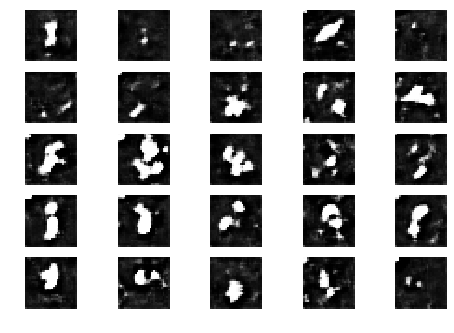

Epoch 0 Batch 1101/1875 [D loss: 0.012476, acc.: 100.00%] [G loss: 0.010185]
Epoch 0 Batch 1102/1875 [D loss: 0.087460, acc.: 96.88%] [G loss: 0.000431]
Epoch 0 Batch 1103/1875 [D loss: 0.004815, acc.: 100.00%] [G loss: 0.008544]
Epoch 0 Batch 1104/1875 [D loss: 0.032780, acc.: 100.00%] [G loss: 0.001361]
Epoch 0 Batch 1105/1875 [D loss: 0.001782, acc.: 100.00%] [G loss: 0.001730]
Epoch 0 Batch 1106/1875 [D loss: 0.040063, acc.: 100.00%] [G loss: 0.000196]
Epoch 0 Batch 1107/1875 [D loss: 0.000980, acc.: 100.00%] [G loss: 0.000176]
Epoch 0 Batch 1108/1875 [D loss: 0.007279, acc.: 100.00%] [G loss: 0.000033]
Epoch 0 Batch 1109/1875 [D loss: 0.000761, acc.: 100.00%] [G loss: 0.002177]
Epoch 0 Batch 1110/1875 [D loss: 0.000640, acc.: 100.00%] [G loss: 0.000787]
Epoch 0 Batch 1111/1875 [D loss: 0.002492, acc.: 100.00%] [G loss: 0.000046]
Epoch 0 Batch 1112/1875 [D loss: 0.002130, acc.: 100.00%] [G loss: 0.000034]
Epoch 0 Batch 1113/1875 [D loss: 0.601528, acc.: 75.00%] [G loss: 0.000008]
E

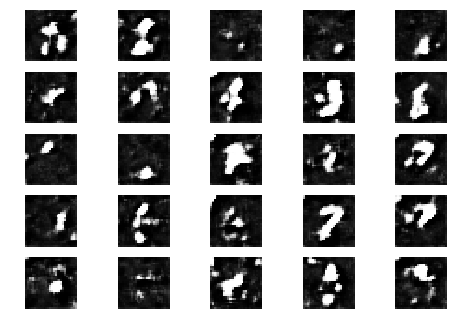

Epoch 0 Batch 1151/1875 [D loss: 0.000324, acc.: 100.00%] [G loss: 0.000013]
Epoch 0 Batch 1152/1875 [D loss: 0.001900, acc.: 100.00%] [G loss: 0.000028]
Epoch 0 Batch 1153/1875 [D loss: 0.000150, acc.: 100.00%] [G loss: 0.000033]
Epoch 0 Batch 1154/1875 [D loss: 0.000484, acc.: 100.00%] [G loss: 0.000068]
Epoch 0 Batch 1155/1875 [D loss: 0.000421, acc.: 100.00%] [G loss: 0.000023]
Epoch 0 Batch 1156/1875 [D loss: 0.001665, acc.: 100.00%] [G loss: 0.000032]
Epoch 0 Batch 1157/1875 [D loss: 0.009648, acc.: 100.00%] [G loss: 0.000107]
Epoch 0 Batch 1158/1875 [D loss: 0.002513, acc.: 100.00%] [G loss: 0.000079]
Epoch 0 Batch 1159/1875 [D loss: 0.001057, acc.: 100.00%] [G loss: 0.000035]
Epoch 0 Batch 1160/1875 [D loss: 0.070928, acc.: 96.88%] [G loss: 0.000099]
Epoch 0 Batch 1161/1875 [D loss: 0.005945, acc.: 100.00%] [G loss: 0.000211]
Epoch 0 Batch 1162/1875 [D loss: 0.049763, acc.: 96.88%] [G loss: 0.000014]
Epoch 0 Batch 1163/1875 [D loss: 0.001689, acc.: 100.00%] [G loss: 0.000004]
E

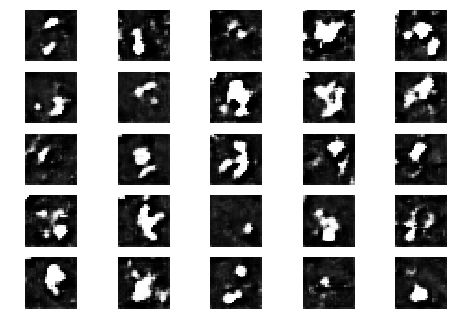

Epoch 0 Batch 1201/1875 [D loss: 0.030589, acc.: 96.88%] [G loss: 0.000077]
Epoch 0 Batch 1202/1875 [D loss: 0.019403, acc.: 100.00%] [G loss: 0.000027]
Epoch 0 Batch 1203/1875 [D loss: 0.001040, acc.: 100.00%] [G loss: 0.000011]
Epoch 0 Batch 1204/1875 [D loss: 0.008479, acc.: 100.00%] [G loss: 0.000012]
Epoch 0 Batch 1205/1875 [D loss: 0.019220, acc.: 100.00%] [G loss: 0.000002]
Epoch 0 Batch 1206/1875 [D loss: 0.001124, acc.: 100.00%] [G loss: 0.000204]
Epoch 0 Batch 1207/1875 [D loss: 0.000063, acc.: 100.00%] [G loss: 0.000014]
Epoch 0 Batch 1208/1875 [D loss: 0.000846, acc.: 100.00%] [G loss: 0.000221]
Epoch 0 Batch 1209/1875 [D loss: 0.002176, acc.: 100.00%] [G loss: 0.000025]
Epoch 0 Batch 1210/1875 [D loss: 0.000299, acc.: 100.00%] [G loss: 0.000081]
Epoch 0 Batch 1211/1875 [D loss: 0.000382, acc.: 100.00%] [G loss: 0.000015]
Epoch 0 Batch 1212/1875 [D loss: 0.000845, acc.: 100.00%] [G loss: 0.000008]
Epoch 0 Batch 1213/1875 [D loss: 0.000982, acc.: 100.00%] [G loss: 0.000026]


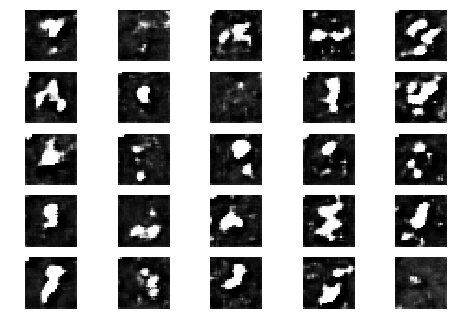

Epoch 0 Batch 1251/1875 [D loss: 0.001418, acc.: 100.00%] [G loss: 0.000006]
Epoch 0 Batch 1252/1875 [D loss: 0.004648, acc.: 100.00%] [G loss: 0.000009]
Epoch 0 Batch 1253/1875 [D loss: 0.001032, acc.: 100.00%] [G loss: 0.000032]
Epoch 0 Batch 1254/1875 [D loss: 0.013125, acc.: 100.00%] [G loss: 0.000011]
Epoch 0 Batch 1255/1875 [D loss: 0.019595, acc.: 100.00%] [G loss: 0.000009]
Epoch 0 Batch 1256/1875 [D loss: 0.002172, acc.: 100.00%] [G loss: 0.000227]
Epoch 0 Batch 1257/1875 [D loss: 0.000282, acc.: 100.00%] [G loss: 0.000026]
Epoch 0 Batch 1258/1875 [D loss: 0.003073, acc.: 100.00%] [G loss: 0.000129]
Epoch 0 Batch 1259/1875 [D loss: 0.000096, acc.: 100.00%] [G loss: 0.000125]
Epoch 0 Batch 1260/1875 [D loss: 0.000874, acc.: 100.00%] [G loss: 0.000065]
Epoch 0 Batch 1261/1875 [D loss: 0.003054, acc.: 100.00%] [G loss: 0.000201]
Epoch 0 Batch 1262/1875 [D loss: 0.008516, acc.: 100.00%] [G loss: 0.000003]
Epoch 0 Batch 1263/1875 [D loss: 0.000098, acc.: 100.00%] [G loss: 0.000205]

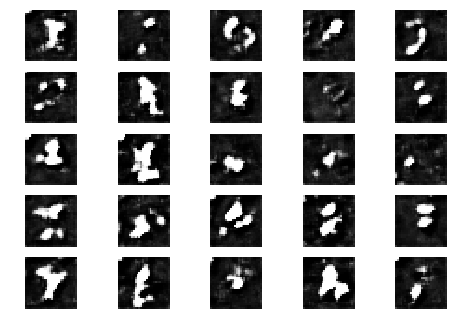

Epoch 0 Batch 1301/1875 [D loss: 0.000734, acc.: 100.00%] [G loss: 0.000049]
Epoch 0 Batch 1302/1875 [D loss: 0.000655, acc.: 100.00%] [G loss: 0.000019]
Epoch 0 Batch 1303/1875 [D loss: 0.000081, acc.: 100.00%] [G loss: 0.000003]
Epoch 0 Batch 1304/1875 [D loss: 0.000509, acc.: 100.00%] [G loss: 0.000002]
Epoch 0 Batch 1305/1875 [D loss: 0.006237, acc.: 100.00%] [G loss: 0.000015]
Epoch 0 Batch 1306/1875 [D loss: 0.003885, acc.: 100.00%] [G loss: 0.000005]
Epoch 0 Batch 1307/1875 [D loss: 0.001583, acc.: 100.00%] [G loss: 0.000003]
Epoch 0 Batch 1308/1875 [D loss: 0.044658, acc.: 96.88%] [G loss: 0.000453]
Epoch 0 Batch 1309/1875 [D loss: 0.003922, acc.: 100.00%] [G loss: 0.000043]
Epoch 0 Batch 1310/1875 [D loss: 0.006295, acc.: 100.00%] [G loss: 0.000014]
Epoch 0 Batch 1311/1875 [D loss: 0.004096, acc.: 100.00%] [G loss: 0.000120]
Epoch 0 Batch 1312/1875 [D loss: 0.000245, acc.: 100.00%] [G loss: 0.000050]
Epoch 0 Batch 1313/1875 [D loss: 0.054731, acc.: 96.88%] [G loss: 0.000014]
E

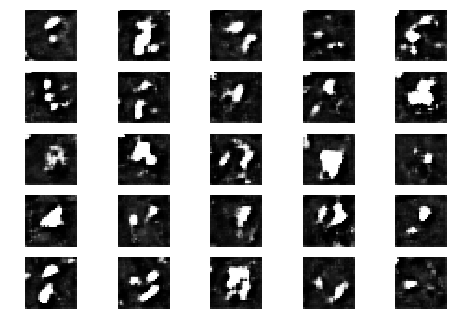

Epoch 0 Batch 1351/1875 [D loss: 0.000502, acc.: 100.00%] [G loss: 0.000002]
Epoch 0 Batch 1352/1875 [D loss: 0.002432, acc.: 100.00%] [G loss: 0.000004]
Epoch 0 Batch 1353/1875 [D loss: 0.056379, acc.: 96.88%] [G loss: 0.000639]
Epoch 0 Batch 1354/1875 [D loss: 0.089175, acc.: 96.88%] [G loss: 0.000001]
Epoch 0 Batch 1355/1875 [D loss: 0.002939, acc.: 100.00%] [G loss: 0.000002]
Epoch 0 Batch 1356/1875 [D loss: 0.000910, acc.: 100.00%] [G loss: 0.000001]
Epoch 0 Batch 1357/1875 [D loss: 0.001698, acc.: 100.00%] [G loss: 0.000000]
Epoch 0 Batch 1358/1875 [D loss: 0.001412, acc.: 100.00%] [G loss: 0.000000]
Epoch 0 Batch 1359/1875 [D loss: 0.002040, acc.: 100.00%] [G loss: 0.000001]
Epoch 0 Batch 1360/1875 [D loss: 0.001107, acc.: 100.00%] [G loss: 0.000001]
Epoch 0 Batch 1361/1875 [D loss: 0.002167, acc.: 100.00%] [G loss: 0.000003]
Epoch 0 Batch 1362/1875 [D loss: 0.000800, acc.: 100.00%] [G loss: 0.000002]
Epoch 0 Batch 1363/1875 [D loss: 0.000892, acc.: 100.00%] [G loss: 0.000022]
E

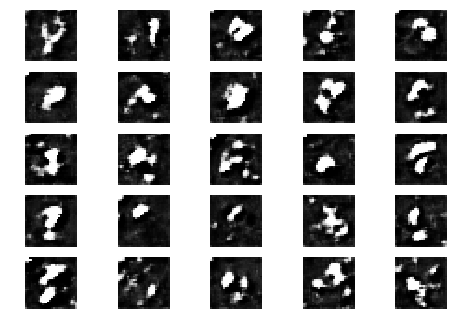

Epoch 0 Batch 1401/1875 [D loss: 0.000478, acc.: 100.00%] [G loss: 0.000015]
Epoch 0 Batch 1402/1875 [D loss: 0.000251, acc.: 100.00%] [G loss: 0.000015]
Epoch 0 Batch 1403/1875 [D loss: 0.017613, acc.: 100.00%] [G loss: 0.000064]
Epoch 0 Batch 1404/1875 [D loss: 0.000781, acc.: 100.00%] [G loss: 0.000002]
Epoch 0 Batch 1405/1875 [D loss: 0.003556, acc.: 100.00%] [G loss: 0.000462]
Epoch 0 Batch 1406/1875 [D loss: 0.012426, acc.: 100.00%] [G loss: 0.000001]
Epoch 0 Batch 1407/1875 [D loss: 0.000454, acc.: 100.00%] [G loss: 0.000003]
Epoch 0 Batch 1408/1875 [D loss: 0.000489, acc.: 100.00%] [G loss: 0.000010]
Epoch 0 Batch 1409/1875 [D loss: 0.001489, acc.: 100.00%] [G loss: 0.000013]
Epoch 0 Batch 1410/1875 [D loss: 0.000121, acc.: 100.00%] [G loss: 0.000001]
Epoch 0 Batch 1411/1875 [D loss: 0.000704, acc.: 100.00%] [G loss: 0.000002]
Epoch 0 Batch 1412/1875 [D loss: 0.000311, acc.: 100.00%] [G loss: 0.000001]
Epoch 0 Batch 1413/1875 [D loss: 0.011379, acc.: 100.00%] [G loss: 0.000000]

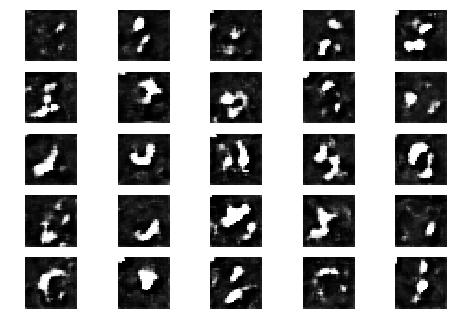

Epoch 0 Batch 1451/1875 [D loss: 0.000192, acc.: 100.00%] [G loss: 0.000129]
Epoch 0 Batch 1452/1875 [D loss: 0.000152, acc.: 100.00%] [G loss: 0.000003]
Epoch 0 Batch 1453/1875 [D loss: 0.000114, acc.: 100.00%] [G loss: 0.000254]
Epoch 0 Batch 1454/1875 [D loss: 0.000076, acc.: 100.00%] [G loss: 0.000003]
Epoch 0 Batch 1455/1875 [D loss: 0.000548, acc.: 100.00%] [G loss: 0.000025]
Epoch 0 Batch 1456/1875 [D loss: 0.000013, acc.: 100.00%] [G loss: 0.000004]
Epoch 0 Batch 1457/1875 [D loss: 0.142268, acc.: 93.75%] [G loss: 0.001486]
Epoch 0 Batch 1458/1875 [D loss: 0.017342, acc.: 100.00%] [G loss: 0.025489]
Epoch 0 Batch 1459/1875 [D loss: 0.484951, acc.: 81.25%] [G loss: 0.000000]
Epoch 0 Batch 1460/1875 [D loss: 0.080731, acc.: 96.88%] [G loss: 0.000000]
Epoch 0 Batch 1461/1875 [D loss: 0.399306, acc.: 84.38%] [G loss: 0.000024]
Epoch 0 Batch 1462/1875 [D loss: 0.030643, acc.: 96.88%] [G loss: 0.002333]
Epoch 0 Batch 1463/1875 [D loss: 0.430100, acc.: 87.50%] [G loss: 0.000000]
Epoch

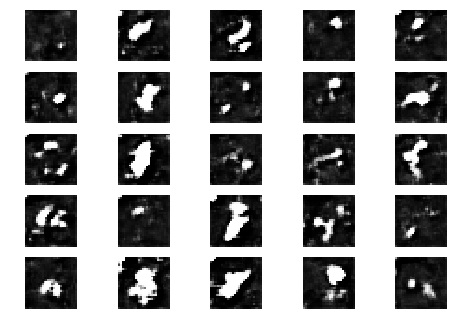

Epoch 0 Batch 1501/1875 [D loss: 0.000046, acc.: 100.00%] [G loss: 0.000006]
Epoch 0 Batch 1502/1875 [D loss: 0.000814, acc.: 100.00%] [G loss: 0.000008]
Epoch 0 Batch 1503/1875 [D loss: 0.004016, acc.: 100.00%] [G loss: 0.000002]
Epoch 0 Batch 1504/1875 [D loss: 0.000015, acc.: 100.00%] [G loss: 0.000001]
Epoch 0 Batch 1505/1875 [D loss: 0.000080, acc.: 100.00%] [G loss: 0.000004]
Epoch 0 Batch 1506/1875 [D loss: 0.004268, acc.: 100.00%] [G loss: 0.000012]
Epoch 0 Batch 1507/1875 [D loss: 0.000148, acc.: 100.00%] [G loss: 0.000001]
Epoch 0 Batch 1508/1875 [D loss: 0.002332, acc.: 100.00%] [G loss: 0.000000]
Epoch 0 Batch 1509/1875 [D loss: 0.000242, acc.: 100.00%] [G loss: 0.000002]
Epoch 0 Batch 1510/1875 [D loss: 0.000661, acc.: 100.00%] [G loss: 0.000001]
Epoch 0 Batch 1511/1875 [D loss: 0.000728, acc.: 100.00%] [G loss: 0.000001]
Epoch 0 Batch 1512/1875 [D loss: 0.000532, acc.: 100.00%] [G loss: 0.000000]
Epoch 0 Batch 1513/1875 [D loss: 0.001121, acc.: 100.00%] [G loss: 0.000001]

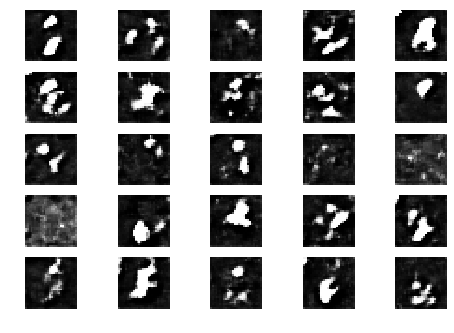

Epoch 0 Batch 1551/1875 [D loss: 0.000347, acc.: 100.00%] [G loss: 0.000000]
Epoch 0 Batch 1552/1875 [D loss: 0.000627, acc.: 100.00%] [G loss: 0.000016]
Epoch 0 Batch 1553/1875 [D loss: 0.000811, acc.: 100.00%] [G loss: 0.000005]
Epoch 0 Batch 1554/1875 [D loss: 0.003787, acc.: 100.00%] [G loss: 0.000000]
Epoch 0 Batch 1555/1875 [D loss: 0.002196, acc.: 100.00%] [G loss: 0.000000]
Epoch 0 Batch 1556/1875 [D loss: 0.000004, acc.: 100.00%] [G loss: 0.000001]
Epoch 0 Batch 1557/1875 [D loss: 0.000062, acc.: 100.00%] [G loss: 0.000000]
Epoch 0 Batch 1558/1875 [D loss: 0.000174, acc.: 100.00%] [G loss: 0.000004]
Epoch 0 Batch 1559/1875 [D loss: 0.001019, acc.: 100.00%] [G loss: 0.000002]
Epoch 0 Batch 1560/1875 [D loss: 0.000569, acc.: 100.00%] [G loss: 0.000000]
Epoch 0 Batch 1561/1875 [D loss: 0.023600, acc.: 100.00%] [G loss: 0.000002]
Epoch 0 Batch 1562/1875 [D loss: 0.000894, acc.: 100.00%] [G loss: 0.000001]
Epoch 0 Batch 1563/1875 [D loss: 0.003307, acc.: 100.00%] [G loss: 0.000000]

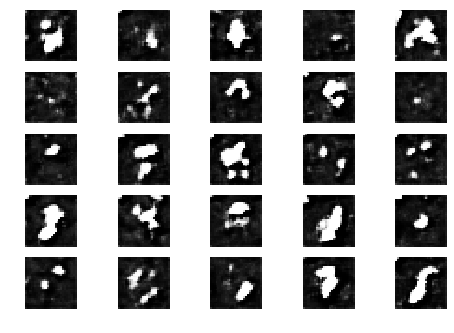

Epoch 0 Batch 1601/1875 [D loss: 0.001054, acc.: 100.00%] [G loss: 0.000000]
Epoch 0 Batch 1602/1875 [D loss: 0.000751, acc.: 100.00%] [G loss: 0.000000]
Epoch 0 Batch 1603/1875 [D loss: 0.000379, acc.: 100.00%] [G loss: 0.000000]
Epoch 0 Batch 1604/1875 [D loss: 0.000059, acc.: 100.00%] [G loss: 0.000022]
Epoch 0 Batch 1605/1875 [D loss: 0.001009, acc.: 100.00%] [G loss: 0.000000]
Epoch 0 Batch 1606/1875 [D loss: 0.011364, acc.: 100.00%] [G loss: 0.000000]
Epoch 0 Batch 1607/1875 [D loss: 0.000402, acc.: 100.00%] [G loss: 0.000006]
Epoch 0 Batch 1608/1875 [D loss: 0.000130, acc.: 100.00%] [G loss: 0.000000]
Epoch 0 Batch 1609/1875 [D loss: 0.000269, acc.: 100.00%] [G loss: 0.000000]
Epoch 0 Batch 1610/1875 [D loss: 0.000304, acc.: 100.00%] [G loss: 0.000001]
Epoch 0 Batch 1611/1875 [D loss: 0.006620, acc.: 100.00%] [G loss: 0.000001]
Epoch 0 Batch 1612/1875 [D loss: 0.003014, acc.: 100.00%] [G loss: 0.000002]
Epoch 0 Batch 1613/1875 [D loss: 0.000057, acc.: 100.00%] [G loss: 0.000000]

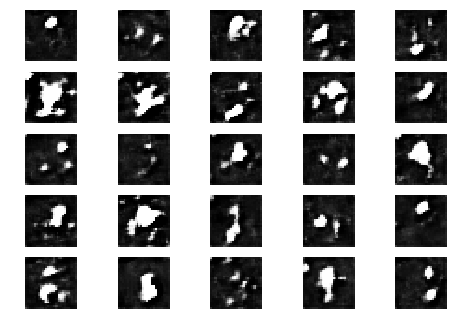

Epoch 0 Batch 1651/1875 [D loss: 0.000021, acc.: 100.00%] [G loss: 0.000001]
Epoch 0 Batch 1652/1875 [D loss: 0.002571, acc.: 100.00%] [G loss: 0.000000]
Epoch 0 Batch 1653/1875 [D loss: 0.018019, acc.: 100.00%] [G loss: 0.000001]
Epoch 0 Batch 1654/1875 [D loss: 0.000024, acc.: 100.00%] [G loss: 0.000001]
Epoch 0 Batch 1655/1875 [D loss: 0.000204, acc.: 100.00%] [G loss: 0.000002]
Epoch 0 Batch 1656/1875 [D loss: 0.000200, acc.: 100.00%] [G loss: 0.000002]
Epoch 0 Batch 1657/1875 [D loss: 0.001313, acc.: 100.00%] [G loss: 0.000006]
Epoch 0 Batch 1658/1875 [D loss: 0.000327, acc.: 100.00%] [G loss: 0.000024]
Epoch 0 Batch 1659/1875 [D loss: 0.000742, acc.: 100.00%] [G loss: 0.000009]
Epoch 0 Batch 1660/1875 [D loss: 0.000367, acc.: 100.00%] [G loss: 0.000012]
Epoch 0 Batch 1661/1875 [D loss: 0.092608, acc.: 96.88%] [G loss: 0.000000]
Epoch 0 Batch 1662/1875 [D loss: 0.007113, acc.: 100.00%] [G loss: 0.000000]
Epoch 0 Batch 1663/1875 [D loss: 0.000191, acc.: 100.00%] [G loss: 0.000000]


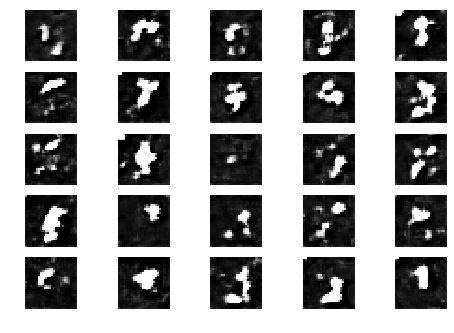

Epoch 0 Batch 1701/1875 [D loss: 0.000153, acc.: 100.00%] [G loss: 0.000153]
Epoch 0 Batch 1702/1875 [D loss: 0.000260, acc.: 100.00%] [G loss: 0.000002]
Epoch 0 Batch 1703/1875 [D loss: 0.000170, acc.: 100.00%] [G loss: 0.000012]
Epoch 0 Batch 1704/1875 [D loss: 0.011365, acc.: 100.00%] [G loss: 0.000000]
Epoch 0 Batch 1705/1875 [D loss: 0.000088, acc.: 100.00%] [G loss: 0.000001]
Epoch 0 Batch 1706/1875 [D loss: 0.000553, acc.: 100.00%] [G loss: 0.000001]
Epoch 0 Batch 1707/1875 [D loss: 0.000040, acc.: 100.00%] [G loss: 0.000007]
Epoch 0 Batch 1708/1875 [D loss: 0.000149, acc.: 100.00%] [G loss: 0.000003]
Epoch 0 Batch 1709/1875 [D loss: 0.000130, acc.: 100.00%] [G loss: 0.000001]
Epoch 0 Batch 1710/1875 [D loss: 0.000133, acc.: 100.00%] [G loss: 0.000003]
Epoch 0 Batch 1711/1875 [D loss: 0.000030, acc.: 100.00%] [G loss: 0.000008]
Epoch 0 Batch 1712/1875 [D loss: 0.000063, acc.: 100.00%] [G loss: 0.000003]
Epoch 0 Batch 1713/1875 [D loss: 0.000534, acc.: 100.00%] [G loss: 0.000001]

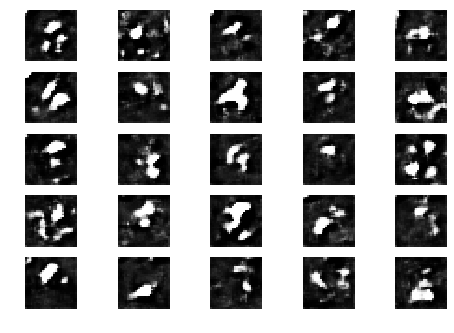

Epoch 0 Batch 1751/1875 [D loss: 0.011640, acc.: 100.00%] [G loss: 0.000035]
Epoch 0 Batch 1752/1875 [D loss: 0.006493, acc.: 100.00%] [G loss: 0.000078]
Epoch 0 Batch 1753/1875 [D loss: 0.097082, acc.: 96.88%] [G loss: 0.000039]
Epoch 0 Batch 1754/1875 [D loss: 0.016394, acc.: 100.00%] [G loss: 0.090932]
Epoch 0 Batch 1755/1875 [D loss: 0.088882, acc.: 93.75%] [G loss: 0.000129]
Epoch 0 Batch 1756/1875 [D loss: 0.036907, acc.: 96.88%] [G loss: 0.000033]
Epoch 0 Batch 1757/1875 [D loss: 0.008166, acc.: 100.00%] [G loss: 0.000189]
Epoch 0 Batch 1758/1875 [D loss: 0.035879, acc.: 96.88%] [G loss: 0.000002]
Epoch 0 Batch 1759/1875 [D loss: 0.069371, acc.: 93.75%] [G loss: 0.000065]
Epoch 0 Batch 1760/1875 [D loss: 0.062869, acc.: 96.88%] [G loss: 0.000392]
Epoch 0 Batch 1761/1875 [D loss: 0.081826, acc.: 96.88%] [G loss: 0.000090]
Epoch 0 Batch 1762/1875 [D loss: 0.035752, acc.: 100.00%] [G loss: 0.000086]
Epoch 0 Batch 1763/1875 [D loss: 0.002092, acc.: 100.00%] [G loss: 0.040586]
Epoch 

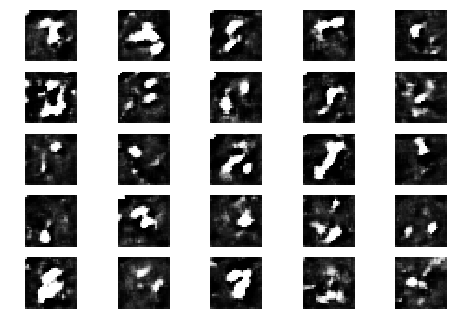

Epoch 0 Batch 1801/1875 [D loss: 0.067474, acc.: 93.75%] [G loss: 0.001699]
Epoch 0 Batch 1802/1875 [D loss: 0.001394, acc.: 100.00%] [G loss: 0.000040]
Epoch 0 Batch 1803/1875 [D loss: 0.150987, acc.: 93.75%] [G loss: 0.000005]
Epoch 0 Batch 1804/1875 [D loss: 0.021994, acc.: 100.00%] [G loss: 0.000000]
Epoch 0 Batch 1805/1875 [D loss: 0.000618, acc.: 100.00%] [G loss: 0.000020]
Epoch 0 Batch 1806/1875 [D loss: 0.082493, acc.: 96.88%] [G loss: 0.000002]
Epoch 0 Batch 1807/1875 [D loss: 0.000478, acc.: 100.00%] [G loss: 0.000015]
Epoch 0 Batch 1808/1875 [D loss: 0.018802, acc.: 100.00%] [G loss: 0.000083]
Epoch 0 Batch 1809/1875 [D loss: 0.011631, acc.: 100.00%] [G loss: 0.000024]
Epoch 0 Batch 1810/1875 [D loss: 0.009312, acc.: 100.00%] [G loss: 0.000113]
Epoch 0 Batch 1811/1875 [D loss: 0.000042, acc.: 100.00%] [G loss: 0.000029]
Epoch 0 Batch 1812/1875 [D loss: 0.001564, acc.: 100.00%] [G loss: 0.000103]
Epoch 0 Batch 1813/1875 [D loss: 0.098473, acc.: 96.88%] [G loss: 0.000004]
Epo

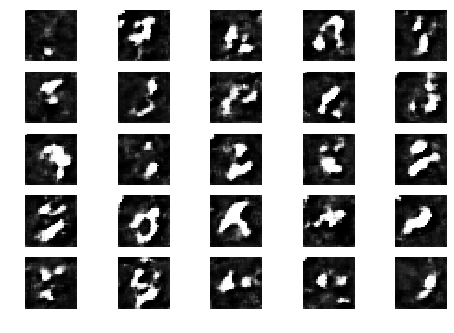

Epoch 0 Batch 1851/1875 [D loss: 0.020489, acc.: 100.00%] [G loss: 0.000036]
Epoch 0 Batch 1852/1875 [D loss: 0.002895, acc.: 100.00%] [G loss: 0.000013]
Epoch 0 Batch 1853/1875 [D loss: 0.001774, acc.: 100.00%] [G loss: 0.000296]
Epoch 0 Batch 1854/1875 [D loss: 0.000502, acc.: 100.00%] [G loss: 0.000010]
Epoch 0 Batch 1855/1875 [D loss: 0.026795, acc.: 100.00%] [G loss: 0.000007]
Epoch 0 Batch 1856/1875 [D loss: 0.004320, acc.: 100.00%] [G loss: 0.000004]
Epoch 0 Batch 1857/1875 [D loss: 0.003630, acc.: 100.00%] [G loss: 0.000001]
Epoch 0 Batch 1858/1875 [D loss: 0.000175, acc.: 100.00%] [G loss: 0.000004]
Epoch 0 Batch 1859/1875 [D loss: 0.001227, acc.: 100.00%] [G loss: 0.000021]
Epoch 0 Batch 1860/1875 [D loss: 0.038560, acc.: 96.88%] [G loss: 0.000075]
Epoch 0 Batch 1861/1875 [D loss: 0.000103, acc.: 100.00%] [G loss: 0.000071]
Epoch 0 Batch 1862/1875 [D loss: 0.016698, acc.: 100.00%] [G loss: 0.000009]
Epoch 0 Batch 1863/1875 [D loss: 0.000996, acc.: 100.00%] [G loss: 0.000082]


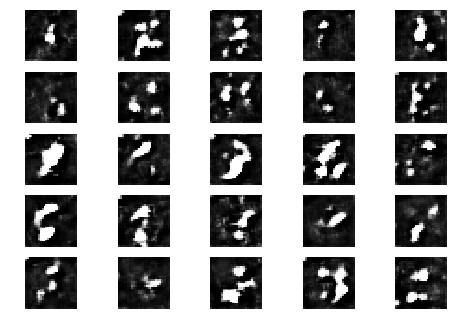

Epoch 1 Batch 1/1875 [D loss: 0.003060, acc.: 100.00%] [G loss: 0.000052]
Epoch 1 Batch 2/1875 [D loss: 0.000011, acc.: 100.00%] [G loss: 0.000011]
Epoch 1 Batch 3/1875 [D loss: 0.000564, acc.: 100.00%] [G loss: 0.000006]
Epoch 1 Batch 4/1875 [D loss: 0.001146, acc.: 100.00%] [G loss: 0.000016]
Epoch 1 Batch 5/1875 [D loss: 0.000595, acc.: 100.00%] [G loss: 0.000000]
Epoch 1 Batch 6/1875 [D loss: 0.033064, acc.: 96.88%] [G loss: 0.000001]
Epoch 1 Batch 7/1875 [D loss: 0.000394, acc.: 100.00%] [G loss: 0.000001]
Epoch 1 Batch 8/1875 [D loss: 0.010092, acc.: 100.00%] [G loss: 0.000000]
Epoch 1 Batch 9/1875 [D loss: 0.021732, acc.: 100.00%] [G loss: 0.000000]
Epoch 1 Batch 10/1875 [D loss: 0.000250, acc.: 100.00%] [G loss: 0.000001]
Epoch 1 Batch 11/1875 [D loss: 0.003212, acc.: 100.00%] [G loss: 0.000089]
Epoch 1 Batch 12/1875 [D loss: 0.058100, acc.: 96.88%] [G loss: 0.000000]
Epoch 1 Batch 13/1875 [D loss: 0.005049, acc.: 100.00%] [G loss: 0.000000]
Epoch 1 Batch 14/1875 [D loss: 0.002

KeyboardInterrupt: ignored

In [41]:
train(generator1, generator2,  discriminator, combined,   epochs=1, batch_size=32, save_interval=1)

In [0]:
    generator1.save('generator1.h5')
    discriminator.save('discriminator1.h5')
    combined.save('combined1.h5')

In [0]:
files.download('generator1.h5')

In [0]:
files.download('discriminator1.h5')

In [0]:
files.download('combined1.h5')

In [0]:
generator1 = load_model('generator1.h5')
discriminator1 = load_model('discriminator1.h5')
combined1 = load_model('combined1.h5')



/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:327: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '
